In [1]:
import io

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as aT
import torchvision.models as models
import torchvision.transforms as vT
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

writer = SummaryWriter()


cuda


## visualize data

Sample Rate: 44100
Shape: (1, 68839)
Dtype: torch.float32
 - Max:     0.683
 - Min:     -0.749
 - Mean:    -2.52e-06
 - Std dev: 0.0948
Waveform: tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.0518e-05, 6.1035e-05,
         6.1035e-05]])


Text(0.5, 1.0, 'Normalized Waveform')

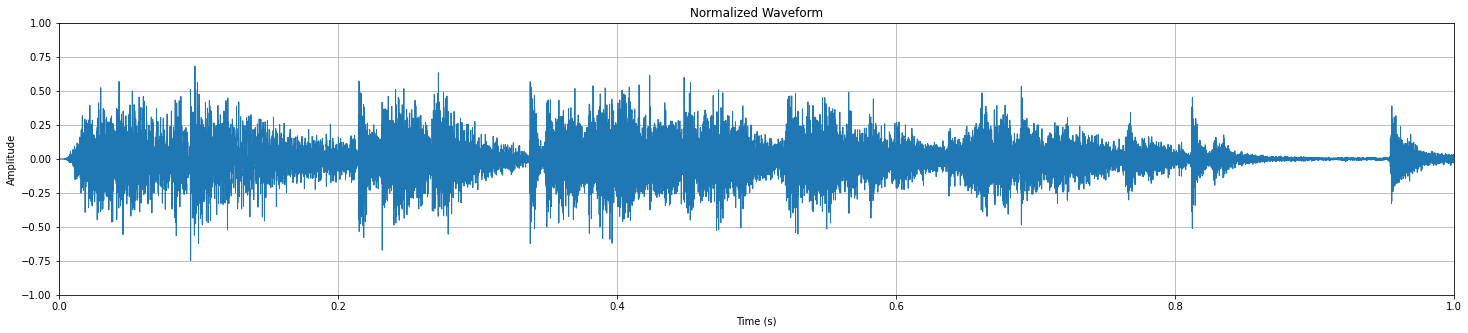

In [3]:
waveform, sample_rate = torchaudio.load('./dataset/5/147867.wav')

print("Sample Rate:", sample_rate)
print("Shape:", tuple(waveform.shape))
print("Dtype:", waveform.dtype)
print(f" - Max:     {waveform.max():.3g}")
print(f" - Min:     {waveform.min():.3g}")
print(f" - Mean:    {waveform.mean():.3g}")
print(f" - Std dev: {waveform.std():.3g}")
print("Waveform:", waveform)

figure = plt.figure(figsize=(25, 5))
time_axis = torch.arange(0, len(waveform[0])) / sample_rate
plt.plot(time_axis, waveform[0], linewidth=1)
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 1)
plt.ylim(-1, 1)
plt.title("Normalized Waveform")


torch.Size([128, 345])


C:\Python39\lib\site-packages\torchaudio\functional\functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


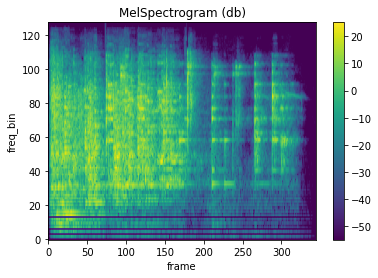

In [4]:
transforms = nn.Sequential(
    aT.MelSpectrogram(),
    aT.AmplitudeToDB(top_db=80.0),
)

spec = transforms(waveform[0])
print(spec.shape)

plt.imshow(spec, origin='lower', aspect='auto')
plt.title('MelSpectrogram (db)')
plt.ylabel('freq_bin')
plt.xlabel('frame')
plt.colorbar()


In [5]:
def plot_signal(signal, title, cmap=None):
    fig = plt.figure()
    if signal.ndim == 1:
        plt.plot(signal)
    else:
        plt.imshow(signal, cmap=cmap)    
    plt.title(title)

    plot_buf = io.BytesIO()
    plt.savefig(plot_buf, format='jpeg')
    plot_buf.seek(0)
    plt.close(fig)

    return vT.ToTensor()(Image.open(plot_buf))

## Load dataset

In [6]:
def audio_loader(path, max_length_in_seconds=4):
    waveform, sample_rate = torchaudio.load(path)
    num_channels, num_frames = waveform.shape
    max_frames = sample_rate * max_length_in_seconds

    # ? Pad audio with zeros if too short or cut audio if too long
    if num_frames < max_frames:
        waveform = torch.nn.functional.pad(waveform, (0, max_frames - num_frames))
    elif num_frames > max_frames:
        waveform = waveform.narrow(dim=1, start=0, length=max_frames)

    return waveform

transforms = nn.Sequential(
    # aT.MFCC(sample_rate=44100, n_mfcc=64),
    aT.MelSpectrogram(sample_rate=44100, n_mels=32),
    aT.AmplitudeToDB(),
)

dataset = DatasetFolder(root='./dataset', loader=audio_loader, extensions='wav', transform=transforms)
print(f"Input shape: {tuple(dataset[0][0].shape)}")

classes = dataset.classes
print("Classes:", classes)

# unique, counts = np.unique([dataset[i][0].shape for i in range(len(dataset))], return_counts=True)
# print(dict(zip(unique, counts)))


Input shape: (1, 32, 883)
Classes: ['1', '2', '3', '4', '5', '6', '7']


In [7]:
train_dataset, valid_dataset = random_split(
    dataset,
    lengths=[int(0.9 * len(dataset)), len(dataset) - int(0.9 * len(dataset))]
)

# ? dataloader
train_dataloader = DataLoader(
    train_dataset.dataset,
    batch_size=4,
    shuffle=False,
    # pin_memory=True,
    # num_workers=2,
)

valid_dataloader = DataLoader(
    valid_dataset.dataset,
    batch_size=4,
    shuffle=True,
    # pin_memory=False,
    # num_workers=2,
)


In [27]:
from models import AudioRNN, AudioCNN

# bands = 60
# frames = 41
# num_features = 1 # 2
# hidden_size = 5300
# num_layers = 1
num_classes = len(classes)

# input_size = bands * frames * num_features
# model = AudioRNN(input_size, hidden_size, num_layers, num_classes)
# model = AudioRNN(input_size, 5300, 1, len(dataset.classes))

model = AudioCNN(num_classes)

# model = models.resnet18(pretrained=True)

# model.conv1 = nn.Conv2d(
#     1,
#     model.conv1.out_channels,
#     kernel_size=model.conv1.kernel_size[0],
#     stride=model.conv1.stride[0],
#     padding=model.conv1.padding[0],
# )
# model.fc = nn.Linear(model.fc.in_features, len(classes))

model.to(device)


AudioCNN(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(80,), stride=(4,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv1d(64, 128, kernel_size=(80,), stride=(4,), padding=(2,))
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv1d(128, 256, kernel_size=(80,), stride=(4,), padding=(2,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv1d(256, 512, kernel_size=(80,), stride=(4,), padding=(2,))
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv1d(512, 512, kernel_size=(40,), stride=(4,), padding=(2,))
    (13): BatchNorm1d(512, eps=1e-05, 

In [28]:
# ? hyperparams

lr = 0.001
num_epochs = 20


In [31]:
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//3, gamma=0.1)
criterion = nn.CrossEntropyLoss()


In [32]:
def train(model, train_loader, criterion, optimizer, epoch, log_interval=10, debug_interval=25):
    model.train()
    train_loss = 0
    num_correct = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # ? zero the parameter gradients
        optimizer.zero_grad()

        # ? forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)

        # ? backward pass
        loss.backward()

        # ? optimize
        optimizer.step()

        train_loss += loss.item()
        num_correct += (predicted == labels).sum().item()

        # ? print training stats
        iteration = epoch * len(train_loader) + batch_idx

        if (batch_idx + 1) % log_interval == 0:
            writer.add_scalar('training loss/loss', loss, iteration)
            writer.add_scalar('learning rate/lr', optimizer.param_groups[0]['lr'], iteration)
            writer.add_scalar('training accuracy/acc', num_correct / (batch_idx * len(labels)), iteration)

        #     print(
        #         f'Epoch: {epoch}\tLoss: {loss:.6f}'
        #         f'[{batch_idx * len(inputs)}/{len(train_loader.dataset)} '
        #         f'({100. * batch_idx / len(train_loader):.0f}%)]'
        #     )

        # ? report debug image every `debug_interval` mini-batches
        # if batch_idx % debug_interval == 0:
        #     for n, (inp, pred, label) in enumerate(zip(inputs, predicted, labels)):
        #         series = (
        #             f'label_{classes[label.cpu()]}'
        #             f'_pred_{classes[pred.cpu()]}'
        #         )

        #         writer.add_image(
        #             f'Train MelSpectrogram samples/{batch_idx}_{n}_{series}',
        #             plot_signal(inp.cpu().numpy().squeeze(), series, 'hot'),
        #             iteration
        #         )

    train_loss /= len(train_loader)
    accuracy = 100 * num_correct / len(train_loader.dataset)

    return train_loss, accuracy

def valid(model, valid_loader, criterion, debug_interval=25):
    model.eval()
    valid_loss = 0
    num_correct = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            print(inputs.shape)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            valid_loss += loss.item()
            num_correct += (predicted == labels).sum().item()

            # iteration = (epoch + 1) * len(valid_loader)
            # if batch_idx % debug_interval == 0:
            #     for n, (inp, pred, label) in enumerate(zip(inputs, predicted, labels)):
            #         series = f'label_{classes[label.cpu()]}_pred_{classes[pred.cpu()]}'

            #         writer.add_image(
            #             f'Test MelSpectrogram samples/{batch_idx}_{n}_{series}', 
            #             plot_signal(inp.cpu().numpy().squeeze(), series, 'hot'), iteration
            #         )

    valid_loss /= len(valid_loader)
    accuracy = 100 * num_correct / len(valid_loader.dataset)

    return valid_loss, accuracy


def predict(model, data):
    model.eval()

    with torch.no_grad():
        data = data.unsqueeze(1).to(device)
        output = model(data)
        accuracy, [predicted] = torch.max(output.data, 1)
        accuracy = 100 * accuracy.item()
        predicted = classes[predicted.item()]

        return predicted, accuracy


In [33]:
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer, epoch=epoch)
    valid_loss, valid_accuracy = valid(model, valid_dataloader, criterion)
    scheduler.step()

    print(
        f'Epoch: {epoch+1}/{num_epochs}\t'
        f'Training (Loss, Accuracy): ({train_loss:.6f}, {train_accuracy:.2f}%)\t'
        f'Validation (Loss, Accuracy): ({valid_loss:.6f}, {valid_accuracy:.2f}%)\t'
    )

    train_losses.append(train_loss), train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss), valid_accuracies.append(valid_accuracy)
    # break


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [64, 1, 80], but got 4-dimensional input of size [4, 1, 32, 883] instead

In [26]:
sample = valid_dataloader.dataset[-1]
predicted, accuracy = predict(model, sample[0])

print(f"Target: {classes[sample[1]]}, Prediction: {predicted}")


Target: 7, Prediction: 4
